# CRIM Project Data Analysis With CRIM Intervals




In [1]:
%config IPCompleter.greedy=True

In [2]:
# from intervals.main_rf import *
from intervals.main import *
from intervals.drb_nb_help import *
import pandas as pd
import re
import altair as alt
import intervals.visualizations as viz
from ipywidgets import interact
from pandas.io.json import json_normalize
from pyvis.network import Network
import requests

music21: Certain music21 functions might need the optional package matplotlib;
                  if you run into errors, install it by following the instructions at
                  http://mit.edu/music21/doc/installing/installAdditional.html


## A. Import an MEI file from CRIM

* Models take the form **CRIM_Model_0000.mei"
* Masses take the form **CRIM_Mass_0000_1**  ("1" in this case means the Kyrie)



### A.1 Import a Piece

In [31]:
piece = 'https://crimproject.org/mei/CRIM_Model_0008.mei'
corpus = CorpusBase([piece])


Memoized piece detected...


### A.2 Check the Title

In [32]:
model = corpus.scores[0]
model.score.metadata.title

'Ave Maria'

# B.  Table of Notes+Rests

* CRIM Intervals is based on **Pandas**, which is a Python code library
* **Pandas Data Frames** are tables that can be processed in all kinds of ways (search for patterns, statistics, visualizations, etc)
* The column at the left is an **index**, in this case corresponding to the **offset** numbers from music21




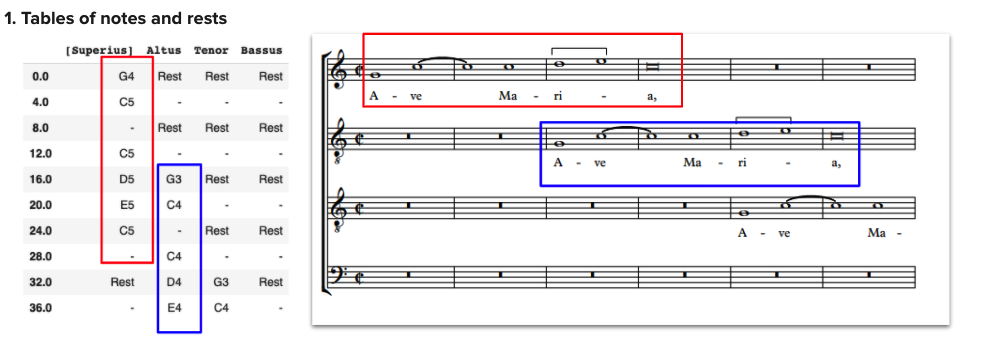

### B.1  Get Table of Notes and Rests

In [33]:
model.getNoteRest().fillna("-")


,[Superius],Altus,Tenor,Bassus
0.0,G4,Rest,Rest,Rest
4.0,C5,-,-,-
8.0,-,Rest,Rest,Rest
12.0,C5,-,-,-
16.0,D5,G3,Rest,Rest
...,...,...,...,...
1256.0,-,-,D4,G3
1268.0,C5,G4,-,-
1272.0,-,-,C4,C3
1284.0,C5,G4,-,-


### B.2 Measures and Beats

* This can be used with any other data frame to translate offsets into measure/beat addresses

In [34]:
nr = model.getNoteRest()
model.detailIndex(nr)

[Superius] Altus Tenor Bassus
Measure Beat                              
1       1.0          G4  Rest  Rest   Rest
        3.0          C5   NaN   NaN    NaN
2       1.0        None  Rest  Rest   Rest
        3.0          C5   NaN   NaN    NaN
3       1.0          D5    G3  Rest   Rest
...                 ...   ...   ...    ...
150     5.0         NaN   NaN    D4     G3
151     3.0          C5    G4   NaN    NaN
        5.0         NaN   NaN    C4     C3
152     3.0          C5    G4   NaN    NaN
        5.0         NaN   NaN    C4     C3

[558 rows x 4 columns]

# C. Melodic Patterns

** CRIM Intervals, as the name suggests, can tell us a lot about the **distances between notes**

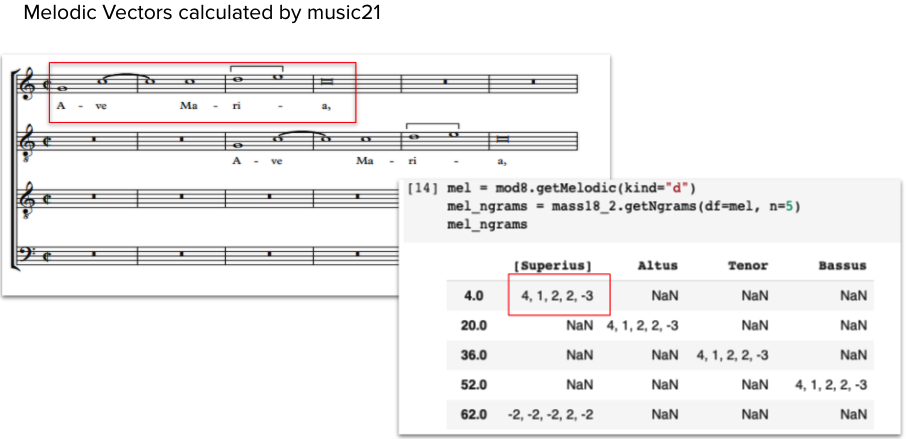


### C.1 Get the melodic intervals for each voice

* Note **kind** is a variable--change it!
    * d = diatonic
    * c = chromatic
    * z = zero-based (so that a unison is represented as "0")

In [35]:
model_melodic = model.getMelodic(kind="d").fillna("-")
model_melodic

,[Superius],Altus,Tenor,Bassus
0.0,-,Rest,Rest,Rest
4.0,4,-,-,-
8.0,-,Rest,Rest,Rest
12.0,1,-,-,-
16.0,2,-,Rest,Rest
...,...,...,...,...
1256.0,-,-,2,-2
1268.0,2,1,-,-
1272.0,-,-,-2,-5
1284.0,1,1,-,-


### C.2 Get Melodic nGrams
* **Ngrams** are used in linguistics (and other fields)--they are continuous strings of characters or events
*  They can be used for measuring similarity or probability
* CRIM Intervals can create **melodic** or **harmonic** nGrams, or some fixed length, or up to the maximum before any rest

#### Compound or Simple?

*  music21 also allows us to select **compound intervals** (10ths and 3rds are the **different**) or **simple intervals** (10ths and 3rds are the **same**)
* compound is thus **true** or **false**

In [36]:
ngrams = model.getNgrams(df=model.getMelodic(kind="d", compound=False), n=4)
ngrams

,[Superius],Altus,Tenor,Bassus
4.0,"4, 1, 2, 2",NaN,NaN,NaN
12.0,"1, 2, 2, -3",NaN,NaN,NaN
20.0,NaN,"4, 1, 2, 2",NaN,NaN
28.0,NaN,"1, 2, 2, -3",NaN,NaN
36.0,NaN,NaN,"4, 1, 2, 2",NaN
...,...,...,...,...
1216.0,NaN,NaN,NaN,"-2, -2, -2, -2"
1236.0,"1, -2, -2, -2","1, 1, -3, 2",NaN,NaN
1240.0,"-2, -2, -2, 2","1, -3, 2, 2","1, -2, 2, 2","8, -4, 2, -2"
1244.0,"-2, -2, 2, 1","-3, 2, 2, 1","-2, 2, 2, -2","-4, 2, -2, -5"


### And now with measure+beat addresses

*  The results of the previous **nGram** method are now 'passed' to the **detailIndex** method

In [37]:
model.detailIndex(ngrams)

[Superius]        Altus         Tenor         Bassus
Measure Beat                                                         
1       3.0      4, 1, 2, 2          NaN           NaN            NaN
2       3.0     1, 2, 2, -3          NaN           NaN            NaN
3       3.0             NaN   4, 1, 2, 2           NaN            NaN
4       3.0             NaN  1, 2, 2, -3           NaN            NaN
5       3.0             NaN          NaN    4, 1, 2, 2            NaN
...                     ...          ...           ...            ...
145     3.0             NaN          NaN   1, -2, 2, 2  1, -2, -2, -2
148     1.0   -2, -2, -2, 2  1, -3, 2, 2   1, -2, 2, 2   8, -4, 2, -2
        3.0   1, -2, -2, -2  1, 1, -3, 2           NaN            NaN
149     1.0             NaN   2, 2, 1, 1   2, 2, -2, 1   2, -2, -5, 1
        3.0    -2, -2, 2, 1  -3, 2, 2, 1  -2, 2, 2, -2  -4, 2, -2, -5

[418 rows x 4 columns]

### C.3 How Many nGrams?

* Pandas includes many **methods** that make it simple to summarize and explore data
    * **stack** assembles all the columns as one
    * **value_counts** tells us how many of each

In [38]:
ngrams.stack().value_counts().to_frame()

,0
"-2, -2, -2, -2",34
"2, -2, -2, -2",26
"-2, -2, -2, 2",21
"1, 2, -2, -2",13
"-2, -2, 2, 2",13
...,...
"-2, 4, 2, 2",1
"2, 1, -5, 8",1
"-3, 2, 5, -3",1
"3, -2, 1, -2",1


### C.4 Search Melodic nGrams

*  Here we can use Python tools to **search for any given 'string' of intervals**, and highlight them in the resulting data frame
    * Note that we can also search at any given **constant time unit** (such as every 2 offsets = half note)
    * To do this we just add **unit=n** to the getNgrams request
    * We can also select to display as offsets or measures/beats
    
* Sample search for Model_0008:  4, 1, 2, 2, -3
    * Notice the regular time intervals--the **classifier** can use this to predict presentation types.

In [39]:
@interact
def get_ngrams(search_pattern="", kind=["d", "c", "z"], compound=[True, False], length=[3, 4, 5, 6], style=["offsets", "measures/beats"], endpoint=["first", "last"]):
    ngrams = model.getNgrams(df=model.getMelodic(kind=kind), n=length, offsets=endpoint)
    mask = ngrams.apply(lambda x: x.astype(str).str.contains(search_pattern).any(), axis=1)
    filtered_ngrams = ngrams[mask].copy()
    bm1 = model.detailIndex(filtered_ngrams)
    if style == "offsets":
        return filtered_ngrams.fillna("-").style.applymap(lambda x: "background: #ccebc5" if search_pattern in x else "")
    else:
        return bm1.fillna("-").style.applymap(lambda x: "background: #ccebc5" if search_pattern in x else "")

interactive(children=(Text(value='', description='search_pattern'), Dropdown(description='kind', options=('d',…

## D. Harmonic Intervals and nGrams

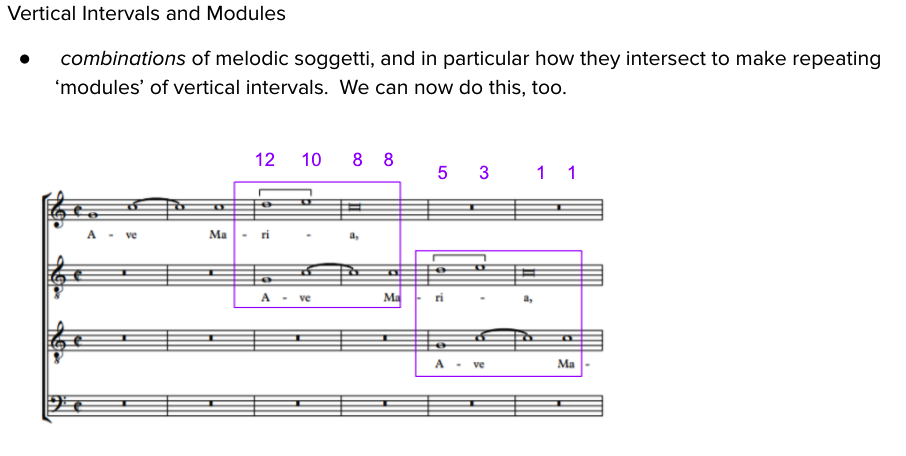

### D.1 getHarmonic

*  we can specify **kind** as above (d, c, z)
* we can choose **compound** or **simple**

In [40]:
model.getHarmonic(kind="d", compound=False).fillna("-")


,Bassus_Tenor,Bassus_Altus,Bassus_[Superius],Tenor_Altus,Tenor_[Superius],Altus_[Superius]
0.0,Rest,Rest,Rest,Rest,Rest,Rest
4.0,-,-,Rest,-,Rest,Rest
8.0,Rest,Rest,Rest,Rest,Rest,Rest
12.0,-,-,Rest,-,Rest,Rest
16.0,Rest,Rest,Rest,Rest,Rest,5
...,...,...,...,...,...,...
1256.0,5,8,3,4,6,-
1268.0,-,8,4,4,7,4
1272.0,8,5,8,5,8,-
1284.0,-,5,8,5,8,4


### D.2 Search Harmonic nGrams

* As above in the case of , we can search for various harmonic events in succession, as nGrams

* We can also search as we did above for Melodic nGrams

* Examples:

    * <mark>Two patterns: 12, 10, 8, 8|5, 3, 1, 1</mark>

    * Authentic cadence:  7, 6, 8


In [41]:
# note that time_unit does not yet work with getHarmonic
@interact
def get_harmonic_ngrams(search_pattern="", kind=["d", "c", "z"], compound=[True, False], length=[3, 4, 5, 6], style=["offsets", "measures/beats"], endpoint=["first", "last"]):    
    model_harmonic = model.getHarmonic(kind=kind, compound=compound)
    ngrams = model.getNgrams(df=model_harmonic, n=length, offsets=endpoint)
    filtered_ngrams = ngrams[ngrams.apply(lambda x: x.astype(str).str.contains(search_pattern).any(), axis=1)].copy()
    bm2 = model.detailIndex(filtered_ngrams)
    if style == "offsets":
        return filtered_ngrams.fillna("-").style.applymap(lambda x: "background: #ccebc5" if search_pattern in x else "")
    else:
        return bm2.fillna("-").style.applymap(lambda x: "background: #ccebc5" if search_pattern in x else "")
    
    return filtered_ngrams.fillna("-").style.applymap(lambda x: "background: #ccebc5" if re.match(search_pattern, x) else "")


interactive(children=(Text(value='', description='search_pattern'), Dropdown(description='kind', options=('d',…

### D.3  Finding Cadence Tones

*  Here we return a 3-gram for a typical cadence, then filter the original list of **Notes and Rests** by those offsets
*  This tells us which pitches are sounding in which voices, which is a proxy for a tonal type for the cadence
* Note that we can provide various settings:  compound, diatonic, length, the endpoint of for purposes of indexing
* Here we show the results by offset and measure/beat

In [42]:
cadence_filter = get_harmonic_ngrams("7, 6, 8", "d", True, 3, "offsets", "last")
cadence_list = cadence_filter.index.tolist()
cadence_tones = model.getNoteRest()
df = cadence_tones.loc[cadence_list,:].fillna("-")
df2 = model.detailIndex(df)
print(df)
print(df2)

       [Superius] Altus Tenor Bassus
232.0          C5    E4    C4     A2
272.0          E5    E4  Rest   Rest
304.0        Rest    B3    E4     E3
416.0          C5    G3    C4     C3
466.0          C5    C4     -      -
472.0          C5    C4    C4     C3
506.0           -     -    C4     C3
512.0          E5  Rest    C4     C3
608.0          C5  Rest    C4     C3
736.0        Rest  Rest    C4     C3
1106.0          -    E4     -      -
1184.0          -     -    C4     C3
             [Superius] Altus Tenor Bassus
Measure Beat                              
30      1.0          C5    E4    C4     A2
35      1.0          E5    E4  Rest   Rest
39      1.0        Rest    B3    E4     E3
53      1.0          C5    G3    C4     C3
59      2.0          C5    C4     -      -
60      1.0          C5    C4    C4     C3
64      2.0           -     -    C4     C3
65      1.0          E5  Rest    C4     C3
77      1.0          C5  Rest    C4     C3
93      2.0        Rest  Rest    C4     C3
131

## E.  Contrapuntal Modules

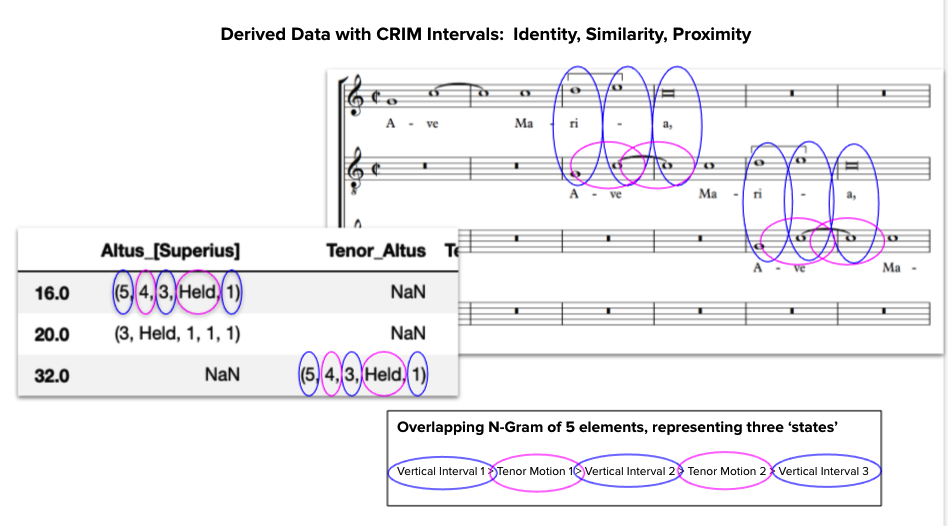

### E.1 Count Modules

* how many of each kind of nGram?

In [43]:
model_har = model.getHarmonic(kind="d", compound=True)
ngrams = model.getNgrams(df=model_har, n=3, how='modules', exclude=['Rest'])
ngrams.stack().value_counts().to_frame()

,0
"6_2, 5_Held, 6",19
"5_Held, 6_2, 5",16
"8_Held, 7_Held, 6",12
"8_-2, 9_-2, 10",9
"5_-2, 6_-2, 8",8
...,...
"15_Held, 15_1, 15",1
"-7_Held, -8_2, -5",1
"4_-4, 6_Held, 5",1
"2_-2, 4_-2, 5",1


### E.2  Search for Modules

* Authentic/Phrygian cadence with suspension in diatonic: 7_Held, 6_-2, 8

* Authentic/Phrygian cadence with suspension in chromatic: 11_Held, 9_-2, 12

* Authentic/Phrygian cadence with suspension in zero-based: 6_Held, 5_-2, 7

In [44]:
@interact
def get_modules(search_pattern="", kind=["d", "c", "z"], compound=[True, False], length=[3, 4, 5, 6], style=["offsets", "measures/beats"], endpoint=["last", "first"]):
    
    model_har = model.getHarmonic(kind=kind, compound=compound)
    ngrams = model.getNgrams(df=model_har, n=length, how='modules', exclude=['Rest'], offsets=endpoint)
    filtered_ngrams = ngrams[ngrams.apply(lambda x: x.astype(str).str.contains(search_pattern).any(), axis=1)].copy()
    bm3 = model.detailIndex(filtered_ngrams)
    if style == "offsets":
        return filtered_ngrams.fillna("-").style.applymap(lambda x: "background: #ccebc5" if search_pattern in x else "")
    else:
        return bm3.fillna("-").style.applymap(lambda x: "background: #ccebc5" if search_pattern in x else "")
    


interactive(children=(Text(value='', description='search_pattern'), Dropdown(description='kind', options=('d',…

## F. Mapping nGrams

In [3]:
corpus = CorpusBase(['https://crimproject.org/mei/CRIM_Model_0008.mei'])
model = corpus.scores[0]
mel = model.getMelodic(kind='d', compound=False, unit=0)
mel_ngrams = model.getNgrams(df=mel, n=5)
# mel_ngrams_tuple = model.getNgrams(df=mel, n=5, cell_type=tuple)
# mel_ngrams_list = model.getNgrams(df=mel, n=5, cell_type=list)

Successfully imported.


In [4]:
mel_ngrams.stack().dropna().value_counts() 

1, 2, -2, -2, -2     13
2, -2, -2, -2, -2    11
1, 1, 2, -2, -2       9
-2, -2, -2, 2, 2      8
2, -3, 2, -2, -2      8
                     ..
2, -2, 2, 2, -2       1
-3, 1, 4, 1, -5       1
2, -2, -2, -2, 8      1
2, -2, -2, 5, -2      1
3, -2, 4, -2, 2       1
Length: 307, dtype: int64

### F.1 Mapping nGrams

In [20]:
nr = model.getNoteRest()
dur = model.getDuration(nr)
dur = dur.applymap(str, na_action='ignore')
nr.reindex_like(dur)
nr_ngrams = model.getNgrams(df=nr, n=5)
dur_ngrams = model.getNgrams(df=dur, n=5)
nr_ngrams

,[Superius],Altus,Tenor,Bassus
0.0,"G4, C5, C5, D5, E5",NaN,NaN,NaN
4.0,"C5, C5, D5, E5, C5",NaN,NaN,NaN
16.0,NaN,"G3, C4, C4, D4, E4",NaN,NaN
20.0,NaN,"C4, C4, D4, E4, C4",NaN,NaN
32.0,NaN,NaN,"G3, C4, C4, D4, E4",NaN
...,...,...,...,...
1212.0,NaN,NaN,NaN,"G3, F3, E3, D3, C3"
1232.0,"E5, E5, D5, C5, B4","G4, G4, G4, E4, F4",NaN,NaN
1236.0,"E5, D5, C5, B4, C5","G4, G4, E4, F4, G4","C4, C4, B3, C4, D4","C3, C4, G3, A3, G3"
1240.0,"D5, C5, B4, C5, C5","G4, E4, F4, G4, G4","C4, B3, C4, D4, C4","C4, G3, A3, G3, C3"


In [19]:
# convert the patterns to string for better display in the heatmap
nr_ngrams  = nr_ngrams.applymap(lambda cell: ", ".join(item for item in cell) if pd.notna(cell) else cell) 

# convert the tuple to the total duration of corresponding ngrams
dur_ngrams = dur_ngrams.applymap(lambda cell: sum(cell) if pd.notna(cell) else cell)

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [22]:
# plot only the most frequent patterns
most_popular = nr_ngrams.stack().head(20).value_counts().index.to_list()
most_popular

['G3, C4, C4, D4, E4',
 'C4, C4, D4, E4, C4',
 'G4, C5, C5, D5, E5',
 'C5, C5, D5, E5, C5',
 'C5, B4, A4, G4, A4',
 'A3, G3, A3, G3, C4',
 'G4, A4, G4, C5, B4',
 'G3, A3, G3, C4, B3',
 'A4, G4, C5, B4, A4',
 'G4, C5, B4, A4, B4',
 'A3, G3, C4, B3, A3',
 'C3, C3, D3, E3, C3',
 'G2, C3, C3, D3, E3',
 'B4, A4, G4, A4, G4',
 'C4, B3, A3, G3, A3',
 'C5, B4, A4, B4, C5',
 'B3, A3, G3, A3, G3',
 'A4, G4, A4, G4, C5']

In [23]:
viz.plot_ngrams_heatmap(nr_ngrams, dur_ngrams, selected_pattern=most_popular, voices=[])

TypeError: unsupported operand type(s) for +: 'float' and 'str'

### F. 2 Similar nGrams

*  Uses **Levenshtein Distance** ("edit distance") to evaluate how many changes must be made to a given nGram to match another.
* https://en.wikipedia.org/wiki/Levenshtein_distance
* The **slider** below determines how close the two melodies must be to count as a match for the given string of intervals.  100 = exact

In [53]:
viz.plot_close_match_heatmap(mel_ngrams, "-2, -3, 2, -2", selected_patterns=[], voices=[])

alt.Chart(...)

## G.  Mapping CRIM Data

* CRIM Data is stored in a format called **JSON**, allows us to retrieve various data fields and their values directly from the CRIM server
* These **structured data** can be queried, mapped, and analyzed in various ways

###  G.1 List the CRIM Relationships

* The list of Pieces that are Models in CRIM Relationships
* We could also find **df_relationships['derivative_observation.piece.piece_id'].unique()**
* The particular piece from the list is chosen via **files[0]**. [0] is just the first piece.

In [95]:
data_relationships = requests.get('http://crimproject.org/data/relationships/').json()
#df = pd.DataFrame(data)
df_relationships = pd.json_normalize(data_relationships)
files = df_relationships['model_observation.piece.piece_id'].unique()
# files = df_relationships['derivative_observation.piece.piece_id'].unique()
df_relationships_0008 = df_relationships[df_relationships['model_observation.piece.piece_id'] == files[15]].copy()

In [96]:


files

array(['CRIM_Model_0011', 'CRIM_Model_0018', 'CRIM_Model_0017',
       'CRIM_Mass_0015_2', 'CRIM_Model_0001', 'CRIM_Model_0020',
       'CRIM_Model_0009', 'CRIM_Model_0019', 'CRIM_Model_0010',
       'CRIM_Model_0022', 'CRIM_Model_0002', 'CRIM_Model_0016',
       'CRIM_Model_0024', 'CRIM_Model_0021', 'CRIM_Mass_0018_1',
       'CRIM_Model_0008', 'CRIM_Mass_0018_3', 'CRIM_Model_0012',
       'CRIM_Model_0023', 'CRIM_Model_0015', 'CRIM_Model_0013',
       'CRIM_Mass_0005_1', 'CRIM_Mass_0016_2', 'CRIM_Mass_0020_3',
       'CRIM_Model_0006', 'CRIM_Model_0025'], dtype=object)

In [97]:
df_relationships_0008.head()

,url,id,relationship_type,musical_type,rt_q,rt_q_x,rt_q_monnayage,rt_tm,rt_tm_snd,rt_tm_minv,...,model_observation.piece.url,model_observation.piece.piece_id,model_observation.piece.full_title,model_observation.ema,derivative_observation.url,derivative_observation.id,derivative_observation.piece.url,derivative_observation.piece.piece_id,derivative_observation.piece.full_title,derivative_observation.ema
871,http://crimproject.org/data/relationships/882/,882,Mechanical transformation,Imitative duo,False,False,False,True,True,False,...,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,"54-65/1-2,1-2,1-2,1-2,1-2,1-3,1-4,3-4,3-4,3-4,...",http://crimproject.org/data/observations/1764/,1764,http://crimproject.org/data/pieces/CRIM_Mass_0...,CRIM_Mass_0005_5,Missa Ave Maria: Agnus Dei,"16-20,25-29/3,3-4,3-4,3-4,3-4,1-2,1-2,1-2,1-2,..."
872,http://crimproject.org/data/relationships/883/,883,Non-mechanical transformation,Periodic entry,False,False,False,False,False,False,...,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,"1-10/1,1-4,1-4,1-4,2-4,2-4,3-4,3-4,4,4/@1-3,@1...",http://crimproject.org/data/observations/1766/,1766,http://crimproject.org/data/pieces/CRIM_Mass_0...,CRIM_Mass_0005_5,Missa Ave Maria: Agnus Dei,"1-8/1-4,1-4,1-4,1-4,1-4,3-4,3-4,3-4/@1-3+@all+..."
971,http://crimproject.org/data/relationships/982/,982,New material,Homorhythm,False,False,False,False,False,False,...,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,1/1/@1-3,http://crimproject.org/data/observations/1964/,1964,http://crimproject.org/data/pieces/CRIM_Mass_0...,CRIM_Mass_0005_5,Missa Ave Maria: Agnus Dei,"34-39/1+4,1+4,1+4,1+4,1+4,1+4/@1-4+@1-4,@1-3+@..."
972,http://crimproject.org/data/relationships/983/,983,Non-mechanical transformation,Soggetto,False,False,False,False,False,False,...,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,"44-46/1,1,1/@3,@1-3,@1",http://crimproject.org/data/observations/1966/,1966,http://crimproject.org/data/pieces/CRIM_Mass_0...,CRIM_Mass_0005_5,Missa Ave Maria: Agnus Dei,"41-45/3-4,3-4,1-4,1-2,1-2/@4+@2-4,@1-3+@1-3,@4..."
973,http://crimproject.org/data/relationships/984/,984,Non-mechanical transformation,"Fuga, Homorhythm",False,False,False,False,False,False,...,http://crimproject.org/data/pieces/CRIM_Model_...,CRIM_Model_0008,Ave Maria,"46-48/1+3-4,1+3-4,1+4/@3+@2-4+@4,@1-3+@1-4+@1-...",http://crimproject.org/data/observations/1968/,1968,http://crimproject.org/data/pieces/CRIM_Mass_0...,CRIM_Mass_0005_5,Missa Ave Maria: Agnus Dei,"45-46/1+3-4,1+3-4/@3-4+@2-3+@3-4,@1-4+@1-3+@1-4"


###  G. 2 A Single Relationship in JSON format

In [99]:
df_relationships_0008.iloc[0, :]

url                                           http://crimproject.org/data/relationships/882/
id                                                                                       882
relationship_type                                                  Mechanical transformation
musical_type                                                                   Imitative duo
rt_q                                                                                   False
rt_q_x                                                                                 False
rt_q_monnayage                                                                         False
rt_tm                                                                                   True
rt_tm_snd                                                                               True
rt_tm_minv                                                                             False
rt_tm_retrograde                                                      

### G.3 Relationship HeatMap

* Here we show **musical types** and **observer**.  We could in fact plot other data, too
* The two bar graphs at the top show the **counts of each type by each person**
* The heatmap at the bottom plots the **individual observations in musical time**
* **Click** on the bar for each musical type to highlight just that type in all the charts
* **Hover** over the individual heat map segment to see certain details
* **Command+Click** on an individual heat map segment to open the observation in CRIMproject.org

In [100]:

viz.plot_relationship_heatmap(df_relationships_0011, 'model_observation.ema', main_category='musical_type', other_category='observer.name', heat_map_width=800,
                              heat_map_height=300)

alt.VConcatChart(...)

### G.4 Observation Heat Map

In [23]:
data_observations = requests.get('http://crimproject.org/data/observations/').json()
#df = pd.DataFrame(data)
df_observations = pd.json_normalize(data_observations)
df_observations_0011 = df_observations[df_observations['piece.piece_id'] == 'CRIM_Model_0011'].copy()
viz.plot_relationship_heatmap(df_observations_0011, 'ema', main_category='musical_type', other_category='observer.name', option=1, heat_map_width=800,
                              heat_map_height=300)

alt.VConcatChart(...)

In [25]:

df_observations_pen = df_observations[df_observations['musical_type']=='Periodic entry'].copy()
df_observations_pen.iloc[0, :]

url                       http://crimproject.org/data/observations/6/
id                                                                  6
ema                     9-12/3-4,2-4,2,2/@4+@1-4,@4+@1-4+@1-3,@1-3,@1
musical_type                                           Periodic entry
mt_cf                                                           False
                                          ...                        
observer.name                                            Drew Ivarson
piece.url           http://crimproject.org/data/pieces/CRIM_Mass_0...
piece.piece_id                                       CRIM_Mass_0009_5
piece.full_title                     Missa Tota pulchra es: Agnus Dei
piece.mass                                             CRIM_Mass_0009
Name: 5, Length: 91, dtype: object